### A/A тесты и проверка качества систем сплитования:
____

![](a_a_test_meme.png)

##### Главная идея:
____
- Перед тем как проводить A/B тест, нам следует провести A/A тест так как именно он покажет грамотная ли у нас система сплитования пользователей, потому что если в результате нашего теста мы получим отрицательный ответ на данный вопрос, то большинство A/B тестов пойдут в пустую так как мы проверяем наличие различий в совершенно неодинаково разделённых выборках.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

А теперь давайте разберём что же такое FPR:

![](fpr_formula.png)

FP — False Positive или I{P≤α}, I — индикаторная функция, P — полученные p-value на каждой итерации синтетического теста, α — уровень альфа, TN — True Negative.

По сути, необходимо проверять FPR на каждом уровне значимости: частота ложных прокрасов не должна быть выше заданного уровня значимости. FPR не должен превышать 0.05 для alpha = 0.05. Соответственно, это должно соблюдаться и для 0.01, 0.005 и т.д.
Также снизу представлена правильная форма рспределение p-values при хорошей системе сплитования и в обратном случае:

![](different_fpr.png)

In [2]:
df = pd.read_csv("hw_aa.csv",sep= ";")
df.drop("Unnamed: 0",axis=1,inplace=True)
df.dropna(inplace=True)
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [3]:
df.size

508072

Выгрузка данных была успешна выполнена,  а теперь давайте зайймёмся A/A тестом, при этом пару слов о цикле:
1. В replace стоит False, чтобы выбранные значения он уже не возвращал;
2. Кол-во итераций ставим не меньше 1000, это моё империческое число, но оно полность соглашается с ограничениями, наложеннные на A/A тест.
____
##### Также, давайте сразу разберём ограничения, наложенные на A/A тест:
1. А/А желательно проводить как можно дольше, чтобы достичь достаточной репрезентативности (охватить недельную сезонность и разные группы пользователей).
2. В случае если нет возможности ждать, то не рекомендуется использовать долгоиграющие метрики для проверки сплита (например, С2).
3. Постсимуляции нужно делать без возвращения наблюдений в сплитах.

  0%|          | 0/1000 [00:00<?, ?it/s]

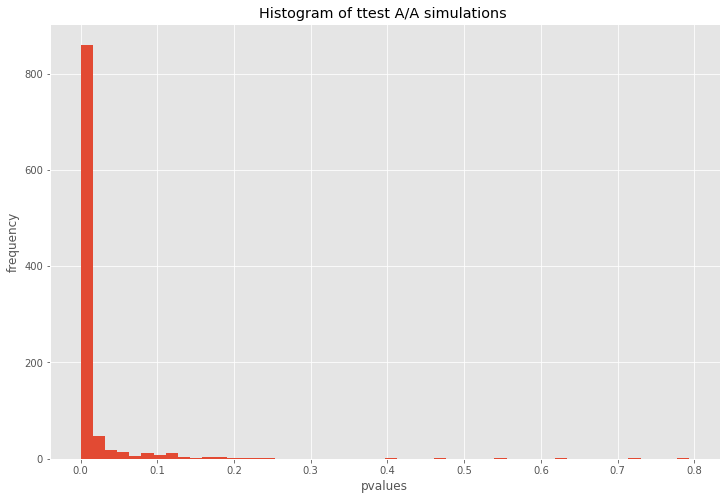

0.931

In [5]:
n = 100000
simulations = 1000
n_s = 1000
res = []
# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df["experimentVariant"] == 1]["purchase"].sample(n_s, replace = False).values
    s2 = df[df["experimentVariant"] == 0]["purchase"].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.figure(figsize=(12,8))
plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Исходя из нашего теста мы видим, что наши p-values распределены ненормальным образом, а также наш FPR явно больше 0.05, а теперь давайте изучим наши данные как настоящий исследователь:

In [6]:
df.groupby("experimentVariant",as_index=False).agg({"purchase":"mean"})

,experimentVariant,purchase
0,0,0.023945
1,1,0.053242


Это уже немного настораживает, ведь наши различия в первой и во второй группе довольно сильно отличаются и надо копать дальше, но это ли не круто изучать наши данные изнутри, что в них вообще творится :)
Наиболее очевидный вариант просто сделать двойную группировку, а агрегацию оставить такой же:

In [7]:
df.groupby(["experimentVariant","version"],as_index=False).agg({"purchase":"mean"})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


А вот и наша аномалия, всего лишь надо было немного поглубже посмотреть на наши данные как тут уже становится очевидно, что шум в нашем A/A тесте добавляет версия приложения "v2.8.0", а теперь давайте проведём наш A/A тест, не используя данную версию в нашем тестировании:

In [8]:
df_new = df.query("version != 'v2.8.0'")
df_new.size

176732

Также как мы видим наш размер данных сильно изменился, но с вопросом по системе сплитования нам лучше уже обратиться к разрабам, кто её делал или если мы её делали, то сделать ревью нашего кода.
А теперь давайте проверим наши средние значения в зависимости от группы в нашем новом датасете.

In [9]:
df_new.groupby("experimentVariant",as_index=False).agg({"purchase":"mean"})

,experimentVariant,purchase
0,0,0.067372
1,1,0.067430


  0%|          | 0/1000 [00:00<?, ?it/s]

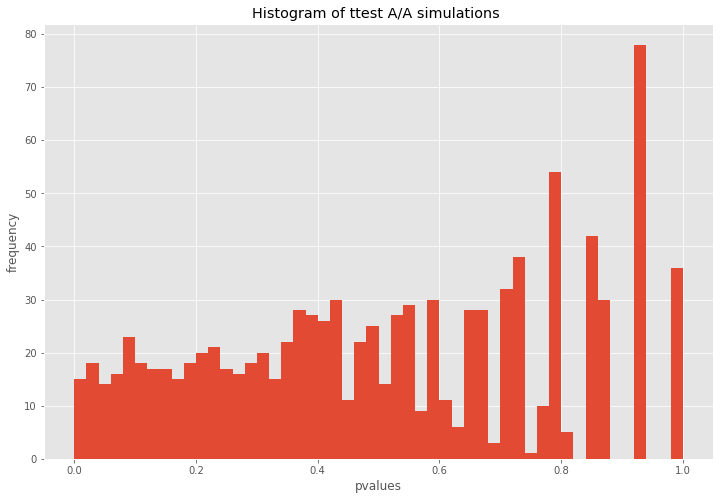

0.039

In [10]:
res_new = []
for i in tqdm(range(simulations)):
    s1 = df_new[df_new["experimentVariant"] == 1]["purchase"].sample(n_s, replace = False).values
    s2 = df_new[df_new["experimentVariant"] == 0]["purchase"].sample(n_s, replace = False).values
    res_new.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.figure(figsize=(12,8))
plt.hist(res_new, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res_new) <0.05) / simulations

### Выводы :
____
Наш FPR меньше 0.05, и это абсолютно нормально, как и небольшие отклонения в большую или меньшую сторону и теперь мы можем запускать нашу новую фичу и раскатывать A/B test.

### Ссылки :
____
1. [Зачем нужен A/A тест](https://www.invespcro.com/blog/aa-tests/);
2. [Доп. информация о FPR](https://en.wikipedia.org/wiki/False_positive_rate);
3. [Другой tutorial по A/A тестам на Python](https://towardsdatascience.com/an-a-b-test-loses-its-luster-if-a-a-tests-fail-2dd11fa6d241).